## Aufgabe 3

### (i) Lest jeweils den nächsten Tag des Forecasts ein und plant darauf den optimalen Speichereinsatz sowie die Verkaufsangebote auf dem Day-Ahead-Markt mit eurer Optimierung aus Aufgabe 1c). (Verwendet die tatsächlichen Preisdaten aus Aufgabe 1)


In [1]:
import pandas as pd
import numpy as np
from gurobipy import *
import os
os.getcwd()

'C:\\Users\\bianca\\Downloads'

In [2]:
df = pd.read_excel("Großhandelspreise_2019.xlsx")
pv = pd.read_csv("PV_2019.csv", header=3)
wind = pd.read_csv("wind_2019.csv", header=3)
#wind_real = pd.read_csv("Wind_real.csv")

In [3]:
wind_forecast = pd.read_csv("Wind_forecast.csv", header=3)
wind_forecast.head(3)

,time,local_time,electricity,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,01.09.2019 00:00,01.09.2019 02:00,2.535175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01.09.2019 01:00,01.09.2019 03:00,2.335636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01.09.2019 02:00,01.09.2019 04:00,3.535083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#wind_forecast datenbereinigung
wind_september = pd.DataFrame(data = wind_forecast['time'])
wind_september['electricity'] = wind_forecast.electricity
#letzten 1419 Zeilen löschen weil NAN drin steht
wind_september.drop(wind_september.tail(1419).index,inplace = True)
wind_september['time'] = pd.to_datetime(wind_september['time'])
wind_september

,time,electricity
0,2019-01-09 00:00:00,2.535175
1,2019-01-09 01:00:00,2.335636
2,2019-01-09 02:00:00,3.535083
3,2019-01-09 03:00:00,2.693114
4,2019-01-09 04:00:00,2.203940
...,...,...
715,2019-09-30 19:00:00,1.876225
716,2019-09-30 20:00:00,2.418040
717,2019-09-30 21:00:00,2.561387
718,2019-09-30 22:00:00,2.109005


In [5]:
#benötigte Daten in df auswählen
df = df[['Datum', 'Anfang', 'Deutschland/Luxemburg [€/MWh]']]
df = df.rename(columns={"Deutschland/Luxemburg [€/MWh]": "Grosshandelspreise"})
df = df.rename(columns={"Anfang": "Uhrzeit"})
#aus Datum und Uhrzeit -> timestamp erstellen
df['time'] = df.apply(lambda row: row["Datum"] + " " + row["Uhrzeit"], axis = 1) 
df['time'] = pd.to_datetime(df['time'], format ="%d.%m.%Y %H:%M")
df

,Datum,Uhrzeit,Grosshandelspreise,time
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00
3,01.01.2019,03:00,-9.91,2019-01-01 03:00:00
4,01.01.2019,04:00,-7.41,2019-01-01 04:00:00
...,...,...,...,...
8755,31.12.2019,19:00,46.00,2019-12-31 19:00:00
8756,31.12.2019,20:00,42.20,2019-12-31 20:00:00
8757,31.12.2019,21:00,39.74,2019-12-31 21:00:00
8758,31.12.2019,22:00,38.88,2019-12-31 22:00:00


In [6]:
df_september = pd.DataFrame(data = df.iloc[5831:6551])
df_september = df_september.reset_index()
df_september= df_september.drop('index', axis=1)
df_september['wind_forecast'] = wind_september.electricity
df_september

,Datum,Uhrzeit,Grosshandelspreise,time,wind_forecast
0,01.09.2019,00:00,27.20,2019-09-01 00:00:00,2.535175
1,01.09.2019,01:00,26.70,2019-09-01 01:00:00,2.335636
2,01.09.2019,02:00,26.47,2019-09-01 02:00:00,3.535083
3,01.09.2019,03:00,25.92,2019-09-01 03:00:00,2.693114
4,01.09.2019,04:00,25.29,2019-09-01 04:00:00,2.203940
...,...,...,...,...,...
715,30.09.2019,19:00,64.37,2019-09-30 19:00:00,1.876225
716,30.09.2019,20:00,57.34,2019-09-30 20:00:00,2.418040
717,30.09.2019,21:00,49.27,2019-09-30 21:00:00,2.561387
718,30.09.2019,22:00,44.58,2019-09-30 22:00:00,2.109005


In [7]:
#Variablen als Listen abspeichern
df_september.Grosshandelspreise = df_september.Grosshandelspreise.astype(float)
df_september['Grosshandelspreise'] = df_september.Grosshandelspreise / 1000
dap = df_september["Grosshandelspreise"].to_list()
wind = df_september["wind_forecast"].to_list()

#Länge festlegen
n_timesteps = len(df_september)

In [8]:
#Erstellt eine Instanz eines Gurobi-Gptimierungsmodells
p  = Model("POP")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


In [9]:
# Zuerst müssen alle Entscheidungsvariablen definiert werden 
wind_direkt = p.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=GRB.INFINITY, name = "wind_d") #was direkt verkauft wird, ub = Unendlich
wind_speicher = p.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=5, name = "wind_s")#wind, das gespeichert wird ub = Leistung Speicher
speicher_raus_w = p.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=5, name = "speicher_d_w") #Kapazität vom Speicher, max 5kw pro Stunde
speicher_w = p.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=15, name = "speicher_w") #Kapazität vom Speicher, max 5kw pro Stunde

#Zielfunktion
p.setObjective((quicksum(dap[t] * (wind_direkt[t] + speicher_raus_w[t]) for t in range(n_timesteps) ) ), GRB.MAXIMIZE) #quicksum(... for t in range(start, end))  bildet die Summe über alle variablen von t=0 bis t=23


#Constraints
p.addConstrs((wind[t] == (wind_speicher[t] + wind_direkt[t]) for t in range(n_timesteps)), "Erzeugter Solarstrom für Periode t") 
p.addConstrs((speicher_w[t] == (speicher_w[t-1]+wind_speicher[t]-speicher_raus_w[t]) for t in range(1,n_timesteps)),"Speicher für Zeitschritt t") #Speicherlast zu Periode t
p.addConstrs((speicher_raus_w[t]<= speicher_w[t-1] for t in range(1,n_timesteps)), "Entladung muss kleiner gleich der gespeicherten Energie sein") 

p.addConstr((speicher_raus_w[0] == 0),"Sonderfall erster Zeitschritt, Speicher ist leer")
p.addConstr((speicher_w[0] ==  0 ) , "Sonderfall erster Zeitschritt")
p.addConstr((speicher_w[n_timesteps-1]== 0), "Sonderfall letzter Zeitschritt")

             
p.optimize() # Hiermit sagen wir explizit, dass jetzt die Optimierung des Modells "p" gestartet werden soll
     

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2161 rows, 2880 columns and 5757 nonzeros
Model fingerprint: 0x7e0c6b3e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-05, 7e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [8e-03, 1e+01]
Presolve removed 730 rows and 731 columns
Presolve time: 0.01s
Presolved: 1431 rows, 2149 columns, 4301 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7078927e+02   5.948186e+05   0.000000e+00      0s
     214    5.2616114e+01   0.000000e+00   0.000000e+00      0s

Solved in 214 iterations and 0.04 seconds (0.02 work units)
Optimal objective  5.261611353e+01


In [10]:
print("Gewinn Börse September 2019 für Wind Anlage von 10kw und Speicher mit Kapazität 15kwh und Leistung 5kw:")
p.getObjective().getValue()


Gewinn Börse September 2019 für Wind Anlage von 10kw und Speicher mit Kapazität 15kwh und Leistung 5kw:


52.61611352830969

In [11]:
def get_results_in_df_w(variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   

    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = p.getVarByName(VarName).x    #Auslesen der Zielvaribale
            except:
                pass
            
    return results_df

In [12]:
wn = ["wind_d", "wind_s", "speicher_d_w", "speicher_w" ] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimeirung)
n = n_timesteps
test_results_wind = get_results_in_df_w(wn, n) # Aufrufen der Funktion und abspeichern meiner Ergebnisse im ''
test_results_wind

,wind_d,wind_s,speicher_d_w,speicher_w
0,2.535175,0.0,0.0,0.0
1,0.0,2.335636,0.0,2.335636
2,0.0,3.535083,0.0,5.870719
3,0.0,2.693114,0.0,8.563833
4,0.0,2.20394,0.0,10.767773
...,...,...,...,...
715,1.876225,0.0,5.0,5.0
716,2.41804,0.0,5.0,0.0
717,2.561387,0.0,0.0,0.0
718,2.109005,0.0,0.0,0.0


In [13]:
#Variablen als Numeric Abspeichern
test_results_wind['speicher_d_w']= pd.to_numeric(test_results_wind["speicher_d_w"])
test_results_wind['speicher_w']= pd.to_numeric(test_results_wind["speicher_w"])

In [14]:
test_results_wind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wind_d        720 non-null    object 
 1   wind_s        720 non-null    object 
 2   speicher_d_w  720 non-null    float64
 3   speicher_w    720 non-null    float64
dtypes: float64(2), object(2)
memory usage: 44.3+ KB


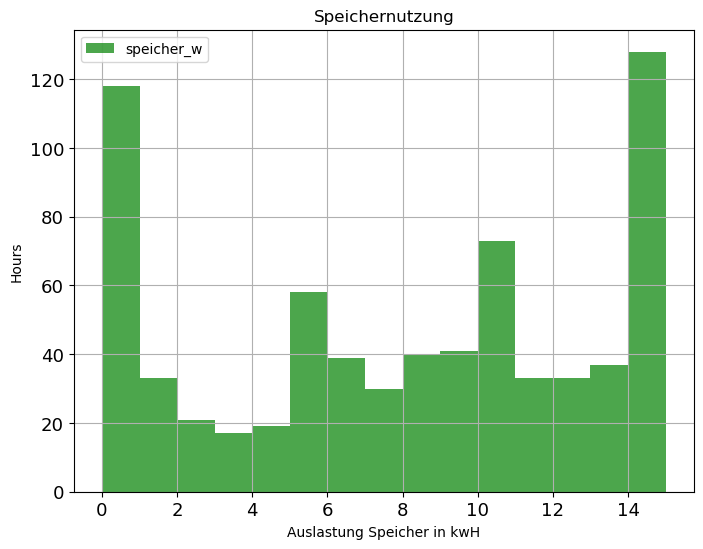

In [15]:
#belegter Speicher nach der Zeit
import matplotlib.pyplot as plt 

test_results_wind.plot(kind='hist',
        alpha=0.7,
        bins=15,
        column = ('speicher_w',),
        title='Speichernutzung',
        #rot=45,
        grid=True,
        figsize=(8,6),
        fontsize=13, 
        color=['g','#FF4F29'])
plt.xlabel('Auslastung Speicher in kwH')
plt.ylabel("Hours")
plt.savefig("VorhergesagteSpeichernutzung.png")
plt.show()

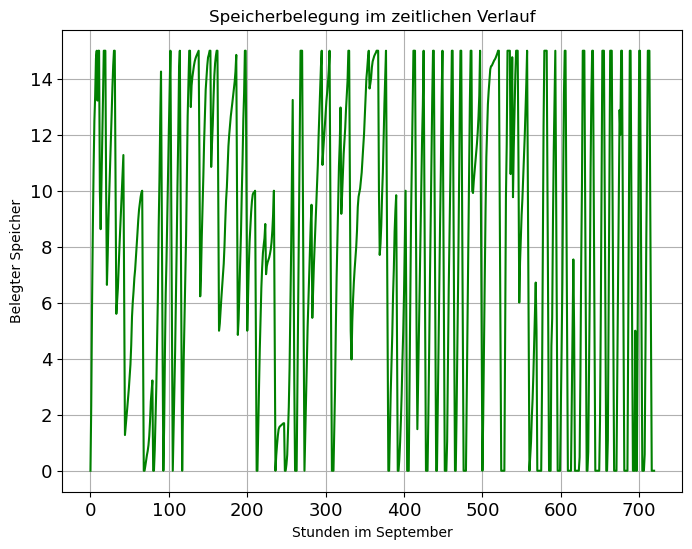

In [16]:
#zeitlicher Verlauf der Speicherbelegung
test_results_wind.speicher_w.plot(
        title='Speicherbelegung im zeitlichen Verlauf',
        grid=True,
        figsize=(8,6),
        fontsize=13, 
        color=['g','#FF4F29'])
plt.xlabel('Stunden im September')
plt.ylabel("Belegter Speicher")
plt.savefig("SpeicherbelegungVorhergesagtGraph.png")
plt.show()

### (ii) Iteriert nun über die Stunden des geplanten Tages in „Echtzeit“. Überprüft dabei in jeder Stunde, wie ihr euren Speicherfahrplan und eure Verkaufsangebote an die tatsächliche Erzeugung anpassen müsst. Wählt für euer Vorgehen eine beliebige Heuristik. Verbleibende Erzeugungsüberschüsse bzw. -defizite könnt ihr auf dem Intradaymarkt ausgleichen (Preisdaten werden hochgeladen).

In [17]:
intraday = pd.read_csv("Preise_Intraday.csv", header=1)
intraday.drop(intraday.tail(40633).index,inplace = True)
intraday

,Delivery day,Hour from,Hour to,ID3-Price
0,30.09.2019,24.0,24.0,27.15
1,30.09.2019,23.0,23.0,37.87
2,30.09.2019,22.0,22.0,42.44
3,30.09.2019,21.0,21.0,47.60
4,30.09.2019,20.0,20.0,56.38
...,...,...,...,...
715,01.09.2019,5.0,5.0,25.67
716,01.09.2019,4.0,4.0,22.36
717,01.09.2019,3.0,3.0,20.52
718,01.09.2019,2.0,2.0,21.25


In [18]:
intraday = intraday.drop('Hour to', axis= 1)
intraday = intraday.rename(columns={"ID3-Price" : "Intradaypreise", "Delivery day": "Datum"})
intraday = intraday[::-1]
intraday = intraday.reset_index()
intraday = intraday.drop('index', axis=1)
intraday.Intradaypreise = intraday.Intradaypreise.astype(float)
intraday['Intradaypreise'] = intraday.Intradaypreise / 1000
intraday

,Datum,Hour from,Intradaypreise
0,01.09.2019,1.0,0.02055
1,01.09.2019,2.0,0.02125
2,01.09.2019,3.0,0.02052
3,01.09.2019,4.0,0.02236
4,01.09.2019,5.0,0.02567
...,...,...,...
715,30.09.2019,20.0,0.05638
716,30.09.2019,21.0,0.04760
717,30.09.2019,22.0,0.04244
718,30.09.2019,23.0,0.03787


#### nicht mehr Forecastingwerte sondern Real-Werte

In [19]:
wind_real = pd.read_csv("Wind_real.csv", header=3)
wind_real

,time,local_time,electricity,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,01.09.2019 00:00,01.09.2019 02:00,3.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01.09.2019 01:00,01.09.2019 03:00,2.988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01.09.2019 02:00,01.09.2019 04:00,2.855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01.09.2019 03:00,01.09.2019 05:00,2.666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01.09.2019 04:00,01.09.2019 06:00,2.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#wind_real datenbereinigung
wind_real_september = pd.DataFrame(data = wind_real['time'])
wind_real_september['electricity'] = wind_real.electricity
#letzten 1419 Zeilen löschen weil NAN drin steht
wind_real_september.drop(wind_real_september.tail(1419).index,inplace = True)
wind_real_september['time'] = pd.to_datetime(wind_real_september['time'])
wind_real_september

,time,electricity
0,2019-01-09 00:00:00,3.000
1,2019-01-09 01:00:00,2.988
2,2019-01-09 02:00:00,2.855
3,2019-01-09 03:00:00,2.666
4,2019-01-09 04:00:00,2.453
...,...,...
715,2019-09-30 19:00:00,1.864
716,2019-09-30 20:00:00,2.010
717,2019-09-30 21:00:00,2.360
718,2019-09-30 22:00:00,2.785


In [21]:
intraday['wind_real'] = wind_september.electricity
intraday

,Datum,Hour from,Intradaypreise,wind_real
0,01.09.2019,1.0,0.02055,2.535175
1,01.09.2019,2.0,0.02125,2.335636
2,01.09.2019,3.0,0.02052,3.535083
3,01.09.2019,4.0,0.02236,2.693114
4,01.09.2019,5.0,0.02567,2.203940
...,...,...,...,...
715,30.09.2019,20.0,0.05638,1.876225
716,30.09.2019,21.0,0.04760,2.418040
717,30.09.2019,22.0,0.04244,2.561387
718,30.09.2019,23.0,0.03787,2.109005


In [23]:
df_september['wind_real'] = wind_real_september.electricity
df_september['wind_direkt'] = test_results_wind.wind_d
df_september['wind_im_Speicher'] = test_results_wind.wind_s
df_september['wind_raus'] = test_results_wind.speicher_d_w
df_september['Kapzität des Speicher'] = test_results_wind.speicher_w
df_september['Intradaypreise'] = intraday['Intradaypreise']
df_september

,Datum,Uhrzeit,Grosshandelspreise,time,wind_forecast,wind_real,wind_direkt,wind_im_Speicher,wind_raus,Kapzität des Speicher,Intradaypreise
0,01.09.2019,00:00,0.02720,2019-09-01 00:00:00,2.535175,3.000,2.535175,0.0,0.0,0.000000,0.02055
1,01.09.2019,01:00,0.02670,2019-09-01 01:00:00,2.335636,2.988,0.0,2.335636,0.0,2.335636,0.02125
2,01.09.2019,02:00,0.02647,2019-09-01 02:00:00,3.535083,2.855,0.0,3.535083,0.0,5.870719,0.02052
3,01.09.2019,03:00,0.02592,2019-09-01 03:00:00,2.693114,2.666,0.0,2.693114,0.0,8.563833,0.02236
4,01.09.2019,04:00,0.02529,2019-09-01 04:00:00,2.203940,2.453,0.0,2.20394,0.0,10.767773,0.02567
...,...,...,...,...,...,...,...,...,...,...,...
715,30.09.2019,19:00,0.06437,2019-09-30 19:00:00,1.876225,1.864,1.876225,0.0,5.0,5.000000,0.05638
716,30.09.2019,20:00,0.05734,2019-09-30 20:00:00,2.418040,2.010,2.41804,0.0,5.0,0.000000,0.04760
717,30.09.2019,21:00,0.04927,2019-09-30 21:00:00,2.561387,2.360,2.561387,0.0,0.0,0.000000,0.04244
718,30.09.2019,22:00,0.04458,2019-09-30 22:00:00,2.109005,2.785,2.109005,0.0,0.0,0.000000,0.03787


In [24]:
#"Heuristik" : immer wenn mehr erzeugt wird, als vorhergesagt, dann können wir die Differenz noch am Intraday Markt verkaufen, falls weniger erzeugt wird müssen wir die Differenz am Intraday Markt einkaufen
umsatz = pd.DataFrame()
umsatz['day_ahead_markt'] = np.zeros(720)
umsatz['intraday'] = np.zeros(720)
for n in range(len(df_september.time)):
        umsatz.day_ahead_markt[n] = (df_september.wind_direkt[n] + df_september.wind_raus[n]) * df_september.Grosshandelspreise[n]
        umsatz.intraday[n] = (df_september.wind_real[n] - df_september.wind_forecast[n]) * df_september.Intradaypreise[n]

print('Der Umsatz in dem Monat September tabellarisch auf dem Day-ahead und Intradaymarkt:')    
umsatz 
    

Der Umsatz in dem Monat September tabellarisch auf dem Day-ahead und Intradaymarkt:


,day_ahead_markt,intraday
0,0.068957,0.009552
1,0.000000,0.013863
2,0.000000,-0.013955
3,0.000000,-0.000606
4,0.000000,0.006393
...,...,...
715,0.442623,-0.000689
716,0.425350,-0.019423
717,0.126200,-0.008547
718,0.094019,0.025600


In [25]:
print('Der gesamte Umsatz in Summe auf dem Day-Ahead Markt beträgt: ', sum(umsatz.day_ahead_markt))
print('Der gesamte Umsatz in Summe auf dem Intraday Markt beträgt: ', sum(umsatz.intraday))

Der gesamte Umsatz in Summe auf dem Day-Ahead Markt beträgt:  52.61611352830973
Der gesamte Umsatz in Summe auf dem Intraday Markt beträgt:  0.6947971595522794


# (iii) Stellt anschließend eure Ein- und Ausgaben am Day-Ahead bzw. Intradaymarkt grafisch oder in einer Tabelle gegenüber. Stellt außerdem euren Speicherbelegungsplan im September grafisch dar.

In [26]:
#Tabellarische Darstellung
umsatz 

,day_ahead_markt,intraday
0,0.068957,0.009552
1,0.000000,0.013863
2,0.000000,-0.013955
3,0.000000,-0.000606
4,0.000000,0.006393
...,...,...
715,0.442623,-0.000689
716,0.425350,-0.019423
717,0.126200,-0.008547
718,0.094019,0.025600


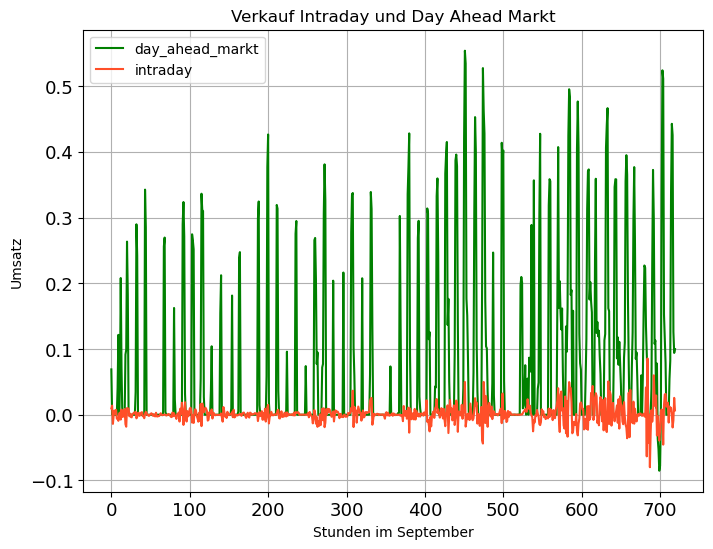

In [27]:
#Plot für Intraday und Day Ahead Markt

umsatz.plot(
        column = ('intraday',),
        title='Verkauf Intraday und Day Ahead Markt',
        grid=True,
        figsize=(8,6),
        fontsize=13, 
        color=['g','#FF4F29'])
plt.xlabel('Stunden im September')
plt.ylabel("Umsatz");
plt.savefig("IntradyDayAhead.png")
plt.show()

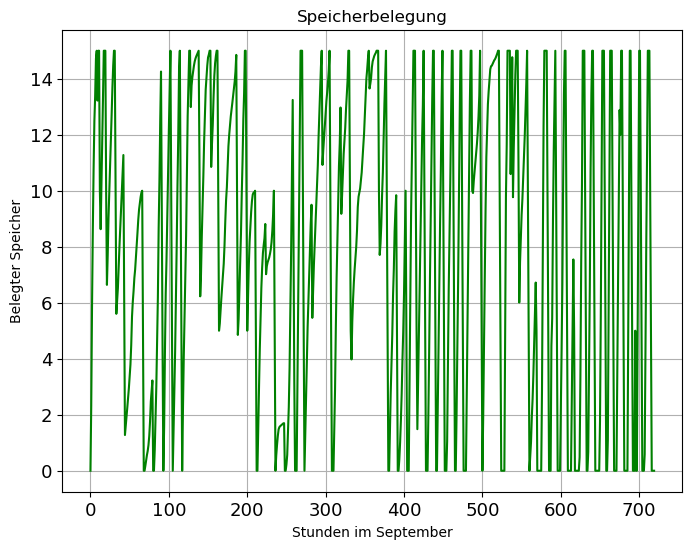

In [28]:
#Ein Plot für Speicherbelegung

test_results_wind.speicher_w.plot(
        title='Speicherbelegung',
        grid=True,
        figsize=(8,6),
        fontsize=13, 
        color=['g','#FF4F29'])
plt.xlabel('Stunden im September')
plt.ylabel("Belegter Speicher")
plt.savefig("Speicherbelegung.png")
plt.show()